# DATA620: Final Project Proposal - Federal Reserve Sentiment

## Homework Team 3: David Simbandumwe, Eric Lehmphul and Lidiia Tronina

Your proposal should describe at a high level what you’re seeking to accomplish, and your motivation for performing this analysis.  A guiding question or hypothesis to test is one good way to start.  If you are going to work in a small group (encouraged!), you should also list your partners’ names. 
You should briefly describe your data sources, plan for doing the work, and up front concerns.  If you are working in a group, please describe the roles and responsibilities of each group member.
We’ll treat this proposal as a planning document, not a blue print containing “firm, fixed requirements.”
Your final project proposal is due on Monday 12/9. 

In [213]:
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import nltk
from nltk.corpus import stopwords
from textblob import Word

import spacy
import spacy.cli
from spacy.lang.en import English

from textatistic import Textatistic


## Functions

In [336]:
def filter_propn(s):
    
    stopwords = spacy.lang.en.stop_words.STOP_WORDS
    
    
    # Load model and create Doc object
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(s)

    # Generate lemmatized tokens
    lemmas = [token.lemma_ for token in doc]

    # Remove stopwords and non-alphabetic tokens
    a_lemmas = [lemma for lemma in lemmas 
                if lemma.isalpha() and lemma not in stopwords]

    a_lemmas = ' '.join(a_lemmas)
    doc_lemmas = nlp(a_lemmas)

    # Generate list of tokens and pos tags
    pos = [(token.text, token.pos_) for token in doc_lemmas]
    
    l = list(zip(*pos))[0]
    l = sorted(set(l))
    
    return ' '.join(l)


def get_city_name(n):
    nlp = spacy.load('en_core_web_sm')

    doc = nlp(n)
    places = [str(ent) for ent in doc.ents if ent.label_ in ['GPE', 'LOC']]

    return ' '.join(places)
   




## Introduction

During the Alan Greenspan era the communications from the Federal Reserve were intentinally opaque. 

Ben Bernanke
Janet Yellen
Jerome Powell

How consistent is the messaging leading up to a decision by Federal Reserve Open Market Committee (FOMC)? We will analyze the speeches from Federal Reserve Chairman to determine if the communication leading up to decision by the FOMC provides visibility into decision. 



#### Federal Reserve System

Federal Reserve Act, created The Federal Reserve System on December 23, 1913. The Federal Reserve acts as the central banking system of the United States of America. The Federal Reserve's system has 3 primary components 
- 12 Federal Reserve Banks 
- Federal Reserve Board of Governors
- Federal Open Market Committee

This a unique structure among central banks in that it includes both public and private characteristics. 

The Fed has many key functions however its activities can be categorized by the Dual Mandate setup by the Congress in the Federal Reserve Act. 
- maximum employment
- stable prices
he dual mandate is the long-run goal for monetary policy, and the Congress also established the Federal Reserve as an independent agency to help ensure that this monetary policy goal can be achieved.

To support these objectives the federal reserve employs monetary policy through 3 primary mechanisms
- open market operations
- the discount rate
- reserve requirements


The Fed has evolved from days of Alen Greenspan when being opaque was a primary focus. How well does the Fed achieve these goals

For this analysis we will focus on the Feds Open Market Operations as carried out by the Federal Open Market Committee and the official communications by FOMC members leading up to official FOMC meetings. At each FOMC meeting the members of the committee will reach consensus on the appropriate monitory policy course. This consensus takes the form a formal communication and directive to the Federal Reserve Bank of New York to execute the transactions on behalf of the Federal Reserve System. 


## Hypothesis
We can categorize the periods between FOMC meeting by their outcome. In each meeting the interest rate target will either be increased, decreased or remain the same. For each type of FOMC meeting outcome we would like to understand if the communication by the representatives of the Fed is consistent. 

- H0 - Communications by Federal Reserve Board Governs do not telegraph the outcome of the upcoming FOMC Meeting. There is no decipherable difference in speeches by FOMC members during periods of increase, decreasing or stable interest rates. 

- H1 - Federal Reserve Board Governs will telegraph the outcome of the upcoming FOMC Meeting through their communications. The speeches by FOMC members differ during periods of increase, decreasing or stable interest rates.  

## Data Source
There are several sources of prepossessed data from the fed however it might be necessary to augment these data set to get the latest

1. Aggregate FOMC Decisions - the outcome of each FOMC meeting is captured in a broader write-up however the decision can be distilled into meeting date, meeting location, decision to increase, decrease or leave interested unchanged, and a magnitude of the change, and the new target range for interest rates
2. Aggregate Speeches by FOMC Members - Each member of the FOMC maintains a detailed calendar of speeches that includes, location, audience, speech title, speech text.

<br>
<b>Potential Sources</b>

Meeting calendars, statements, and minutes (2017-2022)
https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm
https://www.thebalance.com/fomc-meetings-schedule-and-statement-summaries-3305975

Federal Funds Effective Rate (FEDFUNDS)
https://fred.stlouisfed.org/series/FEDFUNDS

List of Governors and their terms
https://en.wikipedia.org/wiki/Federal_Reserve_Board_of_Governors

History of FOMC decisions 
https://www.federalreserve.gov/monetarypolicy/fomc.htm
https://en.wikipedia.org/wiki/History_of_Federal_Open_Market_Committee_actions

In [214]:
decision_df = pd.read_csv('data/Manual_Event.csv')
decision_df['event_date']  = pd.to_datetime(decision_df['event_date'])
decision_df.head()

,id,event_date,fed_rate,action,rate_change,fed_chair,notes
0,1,1987-05-19,0.0650,increase,0.0062,Paul Volcker,Continued raising rates to fight inflation
1,2,1987-07-07,0.0650,no change,0.0000,Alan Greenspan,- no change -
2,3,1987-08-18,0.0650,no change,0.0000,Alan Greenspan,- no change -
3,4,1987-09-22,0.0725,increase,0.0075,Alan Greenspan,No notable event
4,5,1987-11-04,0.0681,decrease,-0.0044,Alan Greenspan,Lowered after Black Monday stock market crash


In [215]:
decision_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           302 non-null    int64         
 1   event_date   302 non-null    datetime64[ns]
 2   fed_rate     302 non-null    float64       
 3   action       302 non-null    object        
 4   rate_change  302 non-null    float64       
 5   fed_chair    302 non-null    object        
 6   notes        302 non-null    object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 16.6+ KB


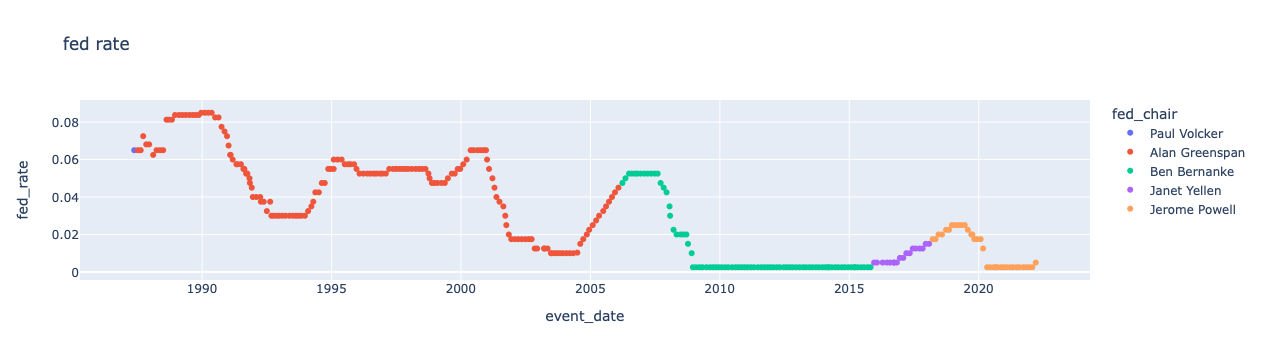

In [216]:
fig = px.scatter(data_frame=decision_df, 
             x='event_date', y='fed_rate', 
             color="fed_chair", 
             title='Fed Rate',   
                )

fig.show()

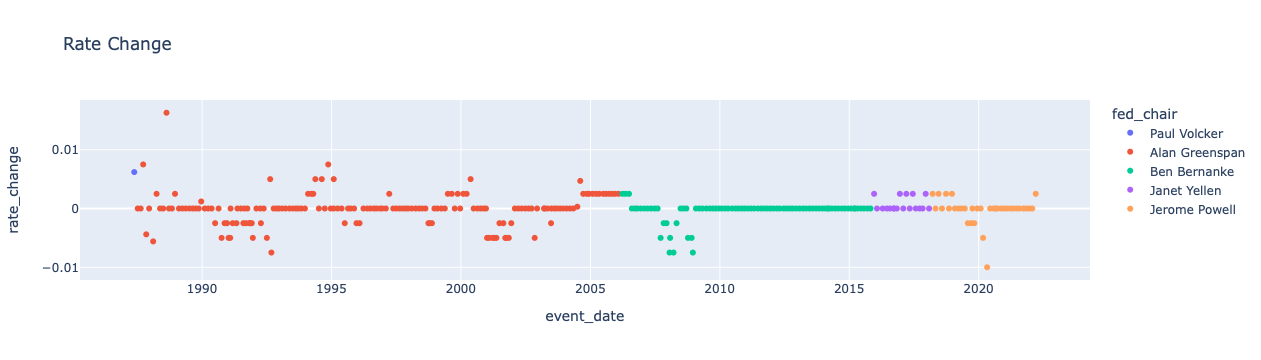

In [217]:
fig = px.scatter(data_frame=decision_df, 
             x='event_date', y='rate_change', 
             color="fed_chair", 
             title='Rate Change',   
                )

fig.show()

In [218]:
speech_df = pd.read_csv('data/fed_speeches_1996_2020.csv', parse_dates=['speech_date'] , encoding='utf_8')
speech_df = speech_df[speech_df['text_len'] > 50]
speech_df['year'] = speech_df['year'].astype(int)
speech_df.head()

,link,title,speaker,event,year,text,speech_date,text_len,location
0,https://www.federalreserve.gov/boarddocs/speec...,Supervision of bank risk-taking,Vice Chair Alice M. Rivlin,At the The Brookings Institution National Issu...,1996,I discovered when I joined the Board of Govern...,1996-12-19,3671,D.C.
1,https://www.federalreserve.gov/boarddocs/speec...,Social security,Chairman Alan Greenspan,At the Abraham Lincoln Award Ceremony of the U...,1996,I am privileged to accept the Union League of...,1996-12-06,2596,Pennsylvania
2,https://www.federalreserve.gov/boarddocs/speec...,The challenge of central banking in a democrat...,Chairman Alan Greenspan,At the Annual Dinner and Francis Boyer Lecture...,1996,The Challenge of Central Banking in a Democrat...,1996-12-05,4344,D.C.
3,https://www.federalreserve.gov/boarddocs/speec...,Clearinghouses and risk management,"Governor Edward W. Kelley, Jr.","At the 1996 Payments System Risk Conference, W...",1996,It is a pleasure to be with you this morning ...,1996-12-03,2527,D.C.
4,https://www.federalreserve.gov/boarddocs/speec...,Supervisory and regulatory responses to financ...,Governor Susan M. Phillips,At the BAI Seminar on Regulatory Policy Change...,1996,Supervisory and Regulatory Responses to Financ...,1996-11-25,2222,D.C.


In [219]:
list_of_values = ['Chairman Alan Greenspan','Chairman Ben S. Bernanke','Chair Janet L. Yellen','Chairman Jerome H. Powell']
speech_df = speech_df[speech_df['speaker'].isin(list_of_values)]
speech_df['speaker'].value_counts(sort=True)

Chairman Alan Greenspan      183
Chairman Ben S. Bernanke     169
Chair Janet L. Yellen         44
Chairman Jerome H. Powell     32
Name: speaker, dtype: int64

In [220]:
speech_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428 entries, 1 to 1443
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   link         428 non-null    object        
 1   title        428 non-null    object        
 2   speaker      428 non-null    object        
 3   event        428 non-null    object        
 4   year         428 non-null    int64         
 5   text         428 non-null    object        
 6   speech_date  428 non-null    datetime64[ns]
 7   text_len     428 non-null    int64         
 8   location     428 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 33.4+ KB


In [221]:
decision_df['date_diff'] = decision_df['event_date'].diff()

In [222]:
decision_df.head()

,id,event_date,fed_rate,action,rate_change,fed_chair,notes,date_diff
0,1,1987-05-19,0.0650,increase,0.0062,Paul Volcker,Continued raising rates to fight inflation,NaT
1,2,1987-07-07,0.0650,no change,0.0000,Alan Greenspan,- no change -,49 days
2,3,1987-08-18,0.0650,no change,0.0000,Alan Greenspan,- no change -,42 days
3,4,1987-09-22,0.0725,increase,0.0075,Alan Greenspan,No notable event,35 days
4,5,1987-11-04,0.0681,decrease,-0.0044,Alan Greenspan,Lowered after Black Monday stock market crash,43 days


In [223]:
decision_df['start_date'] = decision_df['event_date'] - decision_df['date_diff']
decision_df['end_date'] = decision_df['event_date']
df_merge = decision_df.merge(speech_df, how='cross')
df_merge = df_merge.query('speech_date >= start_date and speech_date <= end_date')
df_merge.head(5)

,id,event_date,fed_rate,action,rate_change,fed_chair,notes,date_diff,start_date,end_date,link,title,speaker,event,year,text,speech_date,text_len,location
35959,85,1996-07-03,0.0525,no change,0.0,Alan Greenspan,- no change -,43 days,1996-05-21,1996-07-03,https://www.federalreserve.gov/boarddocs/speec...,Bank supervision in a world economy,Chairman Alan Greenspan,At the International Conference of Banking Sup...,1996,Remarks by Chairman Alan Greenspan Bank superv...,1996-06-13,3164,Sweden
36814,87,1996-09-24,0.0525,no change,0.0,Alan Greenspan,- no change -,35 days,1996-08-20,1996-09-24,https://www.federalreserve.gov/boarddocs/speec...,Regulation and electronic payment systems,Chairman Alan Greenspan,At the U.S. Treasury Conference on Electronic ...,1996,Remarks by Chairman Alan Greenspan Regulation ...,1996-09-19,1948,D.C.
37239,88,1996-11-13,0.0525,no change,0.0,Alan Greenspan,- no change -,50 days,1996-09-24,1996-11-13,https://www.federalreserve.gov/boarddocs/speec...,Technological advances and productivity,Chairman Alan Greenspan,At the 80th Anniversary Awards Dinner of The C...,1996,Remarks by Chairman Alan Greenspan Technologic...,1996-10-16,1690,New York
37240,88,1996-11-13,0.0525,no change,0.0,Alan Greenspan,- no change -,50 days,1996-09-24,1996-11-13,https://www.federalreserve.gov/boarddocs/speec...,U.S. Treasury securities market: Lessons from ...,Chairman Alan Greenspan,At the Annual Public Service Awards Dinner of ...,1996,Remarks by Chairman Alan Greenspan U.S. Treasu...,1996-10-07,1191,New York
37241,88,1996-11-13,0.0525,no change,0.0,Alan Greenspan,- no change -,50 days,1996-09-24,1996-11-13,https://www.federalreserve.gov/boarddocs/speec...,"Bank supervision, regulation, and risk",Chairman Alan Greenspan,At the Annual Convention of the American Banke...,1996,Remarks by Chairman Alan Greenspan Bank superv...,1996-10-05,2346,Hawaii


### events

In [275]:
df_merge['event_key'] = df_merge['event'].apply(filter_propn)

In [276]:
df_merge[['event','event_key']]

,event,event_key
35959,At the International Conference of Banking Sup...,Banking Conference International Stockholm Sup...
36814,At the U.S. Treasury Conference on Electronic ...,Banking Conference Electronic Government Money...
37239,At the 80th Anniversary Awards Dinner of The C...,Anniversary Awards Board Conference Dinner New...
37240,At the Annual Public Service Awards Dinner of ...,Annual Association Awards Dinner New Public Se...
37241,At the Annual Convention of the American Banke...,American Annual Association Bankers Convention...
...,...,...
121103,At the Annual Meeting of the Greater Providenc...,Annual Chamber Commerce Greater Island Meeting...
122407,At the Hutchins Center on Fiscal and Monetary ...,Brookings Center Fiscal Hutchins Institution M...
122833,"At ""A Fed Listens Event: How Is COVID-19 Affec...",Board Community Event Fed Federal Governors Li...
122834,At the Peterson Institute for International Ec...,Economics Institute International Peterson Was...


### locations

In [338]:
df_merge['location_key'] = df_merge['location'].apply(get_city_name)

In [339]:
df_merge[['location','location_key']]

,location,location_key
35959,Sweden,Sweden
36814,D.C.,D.C.
37239,New York,New York
37240,New York,New York
37241,Hawaii,Hawaii
...,...,...
121103,Rhode Island,Rhode Island
122407,D.C. (via webcast),D.C.
122833,D.C. (via webcast),D.C.
122834,D.C. (via webcast),D.C.


In [352]:
df_merge['location_key'].value_counts(sort=True)

D.C.                          125
New York                       36
                               36
Illinois                       27
California                     24
Massachusetts                  21
Georgia                        17
Texas                          11
Virginia                       11
Florida                        11
Missouri                       10
Germany                         8
Pennsylvania                    7
Ohio                            6
South Carolina                  5
England                         5
North Carolina                  4
Rhode Island                    4
Arizona                         4
Japan                           4
France                          4
New Jersey                      3
U.K.                            3
Michigan                        3
Hawaii                          3
Mexico                          3
Nebraska                        2
Sweden                          2
Minnesota                       2
Nevada        

In [346]:
len(df_merge['location_key'].value_counts(sort=True))

55

## Analysis

Review speeches by federal reserve board members. Analysis of Speech Sentiment for consistency with the decision making. Does the Federal reserve do a good job of telegraphing its decisions in speeches leading up to the meeting of the?

1. The outcomes of the FOMC meeting will be used to label speeches by Board Members, Each speech takes place during a period where the FOMC board will decide to increase, decrease or leave interest rates unchanged. The speech can then be parsed for and scored using sentiment analysis

2. The records of the speech will be used to create a network graph where the nodes will be speaker, audience, location?. The edges will be sentiment and the meta data from the relevant FOMC meeting.

3. Grouping the communications by FOMC Meeting outcome, Speaker, Audience, Time frame we can analyze the clarity of message from the Federal Reserve.



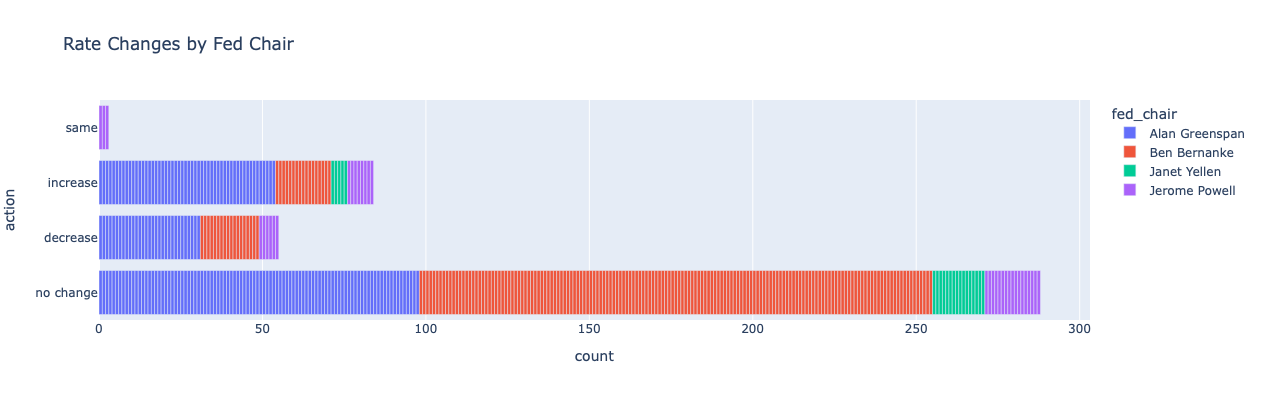

In [356]:
fig = px.bar(df_merge, y="action", color='fed_chair', orientation='h',
             hover_data=["action", "rate_change"],
             height=400,
             title='Rate Changes by Fed Chair')
fig.show()

# sentiment analysis

In [357]:
 # Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# Create CountVectorizer object
vectorizer = CountVectorizer(strip_accents='ascii', stop_words='english', lowercase=False)
# Import train_test_split
from sklearn.model_selection import train_test_split
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_merge['text'], df_merge['action'], test_size=0.25)

In [358]:
# Generate training Bow vectors
X_train_bow = vectorizer.fit_transform(X_train)
# Generate test BoW vectors
X_test_bow = vectorizer.transform(X_test)

In [362]:
 # Import MultinomialNB
from sklearn.naive_bayes import MultinomialNB
# Create MultinomialNB object
clf = MultinomialNB()
# Train clf
clf.fit(X_train_bow, y_train)
# Compute accuracy on test set
accuracy = clf.score(X_test_bow, y_test)
print(accuracy)


0.5833333333333334


In [364]:
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X_test_bow)
print(confusion_matrix(y_test, y_pred))


[[ 0  3  8  0]
 [ 0  5 12  0]
 [ 4 16 58  0]
 [ 0  0  2  0]]


## Concerns

## Final Thoughts

## Project Plan

### Team Roles

### Work Plan

## Other Links:
    
- https://www.youtube.com/watch?v=A9bQzmE6QGw

- https://www.youtube.com/watch?v=VzMiRsSOctI&t=1487s